In [2]:
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
import cv2 as cv
import math

# Singular Value Decomposition 

In [3]:
def sign(number):
    return 1 if (round(number, 3) > 0) else -1
    
def hypotenuse(a, b):
    return math.sqrt(a**2 + b**2)

def isFlipped(matrix):
    row, col = matrix.shape
    return (row < col)

In [4]:
def getEigenRight(mat, eps = 1.e-5):
    smat = np.matmul(mat.T, mat)

    # Params
    hess, singularMatrix = linalg.hessenberg(smat, calc_q=True)
    diag = [np.float64(val) for val in np.diag(hess)]
    subdElmt = [np.float64(val) for val in np.diag(hess, -1)]

    # Start
    n = len(diag)
    itermax = 1//eps**2
    subdElmt.append(0)

    for l in range(n):
        j = 0
        while True:
            m = l
            while True:
                # Convergence test
                if (m + 1) == n:
                    break
                if abs(subdElmt[m]) <= eps * (abs(diag[m]) + abs(diag[m + 1])):
                    break 
                m += 1
            
            if m == l:
                break 
            
            if j >= itermax:
                raise RuntimeError(f"No convergence to eigenvalue after {j} iteration.")

            j += 1

            # Form shift
            p = diag[l]
            g = (diag[l + 1] - p) / (2 * subdElmt[l])
            r = hypotenuse(g, 1)

            # Avoiding cancelation
            s = g + sign(g)*r

            g = diag[m] - p + subdElmt[l] / s

            s, c, p = 1, 1, 0

            for i in range(m - 1, l - 1, -1):
                f = s * subdElmt[i]
                b = c * subdElmt[i]
                if abs(f) > abs(g):
                    c = g / f 
                    r = hypotenuse(c, 1)
                    subdElmt[i + 1] = f * r 
                    s = 1 / r
                    c *= s
                else:
                    s = f / g 
                    r = hypotenuse(s, 1)
                    subdElmt[i + 1] = g * r 
                    c = 1 / r 
                    s *= c 
                
                g = diag[i + 1] - p 
                r = (diag[i] - g) * s + 2 * c * b 
                p = s * r 
                diag[i + 1] = g + p 
                g = c * r - b 

                # Compute eigenvectors
                singularMatrix[:, i:i + 2] = singularMatrix[:, i:i + 2]\
                                            .dot(np.array([[c, s],
                                                          [-s, c]], dtype=np.float64))
 
            diag[l] -= p; subdElmt[l] = g; subdElmt[m] = 0

    sortedIdx = np.argsort(diag)[::-1][:n]
    eigenval = diag.copy()
    eigenval.sort(reverse=True)
    singularMatrix = singularMatrix[:, sortedIdx]

    negIdx = [eigenval.index(val) for val in eigenval if val < 0]
    for i in negIdx:
        eigenval[i] *= -1
        singularMatrix[i, :] *= -1

    return eigenval, singularMatrix

In [5]:
def getSVD(matrix):
    mcopy = matrix.copy()
    row, col = mcopy.shape

    # Column should be higher than row
    if isFlipped(matrix):
        mcopy = mcopy.T
        row, col = mcopy.shape

    u = np.zeros((row, row))
    eigval, v = getEigenRight(mcopy)

    sigma = [math.sqrt(x) for x in eigval]

    # Compute u from v
    for i in range(col):
        u[:, i] = (mcopy @ v[:, i]) / sigma[i]

    return u, sigma, v

In [6]:
def getReducedMatrix(matrix, percent):
    row, col = matrix.shape
    u, sigma, v = getSVD(matrix)

    maxrank = len([1 for s in sigma if s != 0.0])
    rank = int(percent * maxrank * 1.e-2)

    dim = (col, row) if isFlipped(matrix) else (row, col)
    reduced = np.matrix(np.zeros(dim, dtype=np.float64))
    for i in range(rank):
        ui = np.matrix(u[:, i]).T
        vi = np.matrix(v.T[i, :])
        reduced += ui * sigma[i] @ vi

    if isFlipped(matrix):
        return reduced.T
    else:
        return reduced

# Read Image

In [7]:
img = cv.imread("lena.png")
b, g, r = cv.split(img)
img.shape

(850, 850, 3)

In [8]:
perc = 100
reducedRed = getReducedMatrix(r, perc)
reducedGreen = getReducedMatrix(g, perc)
reducedBlue = getReducedMatrix(b, perc)

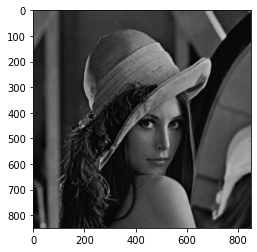

In [9]:
res = cv.merge((reducedRed, reducedGreen, reducedBlue)).astype('uint8')
plt.imshow(res)
plt.show()

In [10]:
imgname = "lena.png"
percent = 100
img = cv.imread(imgname)

b, g, r = cv.split(img)
reducedRed = getReducedMatrix(r, percent)
reducedGreen = getReducedMatrix(g, percent)
reducedBlue = getReducedMatrix(b, percent)

compressed = cv.merge((reducedRed, reducedGreen, reducedBlue)).astype('uint8')
cv.imwrite(f"{percent}_{imgname}", compressed)